### This notebook contains both Encoder-Decoder and Encoder Only approaches

In [1]:
import nltk
from nltk.corpus import names
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, GlobalAveragePooling1D, TimeDistributed
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd

# Load NLTK names dataset
nltk.download('names')
male_names = names.words('male.txt')
female_names = names.words('female.txt')

[nltk_data] Downloading package names to /Users/laasya/nltk_data...
[nltk_data]   Package names is already up-to-date!


In [2]:
# Combine and encode names
all_names = male_names + female_names
labels = [0] * len(male_names) + [1] * len(female_names)  # 0 for male, 1 for female

# Convert names to ASCII values
names_ascii = [[ord(char) for char in name.lower()] for name in all_names]

# Pad sequences
names_padded = pad_sequences(names_ascii, padding='post')

# Shuffle data
indices = np.arange(len(labels))
np.random.shuffle(indices)
names_padded = names_padded[indices]
labels = np.array(labels)[indices]


In [3]:
print(f"Number of Male Names:",len(male_names))
print(f"Number of Female Names:", len(female_names))

Number of Male Names: 2943
Number of Female Names: 5001


#### Imbalanced classes - Let's adjust class weights

In [4]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
names_train, names_test, labels_train, labels_test = train_test_split(names_padded, labels, test_size=0.2, random_state=42)

# Split train data into train and val sets
names_train, names_val, labels_train, labels_val = train_test_split(names_train, labels_train, test_size = 0.25, random_state = 42)

In [5]:
# The dataset is heavily imbalanced
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights which will be passed to model during training
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_train),
    y=labels_train)

class_weight_dict = dict(enumerate(class_weights))

In [6]:
# Decode Names
def decode_names(encoded_names):
    decoded_names = []
    for name in encoded_names:
        decoded_name = ''.join(chr(char) for char in name if char != 0)  # Convert ASCII back to characters and ignore padding
        decoded_names.append(decoded_name)
    return decoded_names

decoded_names_test = decode_names(names_test)

label_map = lambda x: "Male" if x == 0 else "Female"

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model

In [8]:
def get_positional_encoding(max_seq_length, d_model):
    angle_rads = np.arange(max_seq_length)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [9]:
def scaled_dot_product_attention(q, k, v, mask):    
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    
    # Scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # Add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # Softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

class MultiHeadAtention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0  # Ensure the model size is divisible by the number of heads

        self.depth = d_model // self.num_heads  # Define the depth

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # scaled_dot_product_attention function needs to be correctly implemented or called here
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

In [10]:
def transformer_encoder(inputs, num_heads, d_model, dff, rate):
    # Multi-head attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
    attn_output = Dropout(rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    # Feed forward network
    ffn_output = Dense(dff, activation='relu')(out1)
    ffn_output = Dense(d_model)(ffn_output)
    ffn_output = Dropout(rate)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

In [11]:
def transformer_decoder(inputs, enc_output, num_heads, d_model, dff, rate):
    # Encoder-decoder attention
    attn1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, enc_output)
    attn1 = Dropout(rate)(attn1)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn1)

    # Feed forward network
    ffn = Dense(dff, activation='relu')(out1)
    ffn = Dense(d_model)(ffn)
    ffn = Dropout(rate)(ffn)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn)

# Encoder-Decoder approach

I am going to try encoder-decoder approach. A decoder is not necessary for a binary classification. I will also try Encoder only after this.

In [12]:
def build_transformer_classifier(vocab_size, max_length, num_layers, num_heads, d_model, dff, rate=0.1):
    inputs = Input(shape=(max_length,))
    embeddings = Embedding(vocab_size, d_model)(inputs)
    
    # Encoder processing
    enc_output = embeddings
    for _ in range(num_layers):
        enc_output = transformer_encoder(enc_output, num_heads, d_model, dff, rate)

    # Decoder processing
    dec_output = enc_output
    for _ in range(num_layers):
        dec_output = transformer_decoder(dec_output, enc_output, num_heads, d_model, dff, rate)

    # Using the output from the last token for classification
    final_output = dec_output[:, -1, :]  # Assuming the last token's output is representative

    outputs = Dense(2, activation='softmax')(final_output)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Encoder only approach

In [13]:
def build_encoder_only_classifier(vocab_size, max_length, num_layers, num_heads, d_model, dff, rate=0.1):
    inputs = Input(shape=(max_length,))
    embeddings = Embedding(vocab_size, d_model)(inputs)
    
    enc_output = embeddings
    for _ in range(num_layers):
        enc_output = transformer_encoder(enc_output, num_heads, d_model, dff, rate)
    cls_token_output = enc_output[:, 0, :]  # This assumes that the first token is like a CLS token

    outputs = Dense(2, activation='softmax')(cls_token_output)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Training the Models

In [14]:
# Assuming models are built and compiled, and data is prepared
from tensorflow.keras.callbacks import EarlyStopping

vocab_size = 128
max_length = 15
num_layers = 2
num_heads = 8
d_model = 32
dff = 256
rate = 0.01

# Setup for Transformer model
transformer_model = build_transformer_classifier(vocab_size, max_length, num_layers, num_heads, d_model, dff, rate)

# Setup for Encoder only model
encoder_only = build_encoder_only_classifier(vocab_size, max_length, num_layers, num_heads, d_model, dff, rate)

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("#"*140)
print("Transformer based Encoder-Decoder approach.")
# Train the Encoder-Decoder model
ed_history = transformer_model.fit(
    names_train, labels_train,
    # class_weight=class_weight_dict,
    validation_data=(names_val, labels_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

print("#"*140)
print("Transformer based Encoder only approach.")
# Train the Encoder Only model
e_history = encoder_only.fit(
    names_train, labels_train,
    # class_weight=class_weight_dict,
    validation_data=(names_val, labels_val),
    epochs=20,
    batch_size=32,
    # callbacks=[early_stopping]
)

############################################################################################################################################
Transformer based Encoder-Decoder approach.
Epoch 1/20
149/149 [==============================] - 4s 18ms/step - loss: 0.6594 - accuracy: 0.6341 - val_loss: 0.6294 - val_accuracy: 0.6576
Epoch 2/20
149/149 [==============================] - 3s 21ms/step - loss: 0.5768 - accuracy: 0.6956 - val_loss: 0.5981 - val_accuracy: 0.6841
Epoch 3/20
149/149 [==============================] - 3s 21ms/step - loss: 0.5660 - accuracy: 0.7100 - val_loss: 0.5884 - val_accuracy: 0.7004
Epoch 4/20
149/149 [==============================] - 4s 24ms/step - loss: 0.5683 - accuracy: 0.7086 - val_loss: 0.5488 - val_accuracy: 0.7174
Epoch 5/20
149/149 [==============================] - 4s 25ms/step - loss: 0.5554 - accuracy: 0.7193 - val_loss: 0.5476 - val_accuracy: 0.7294
Epoch 6/20
149/149 [==============================] - 4s 25ms/step - loss: 0.5527 - accuracy: 0.7262

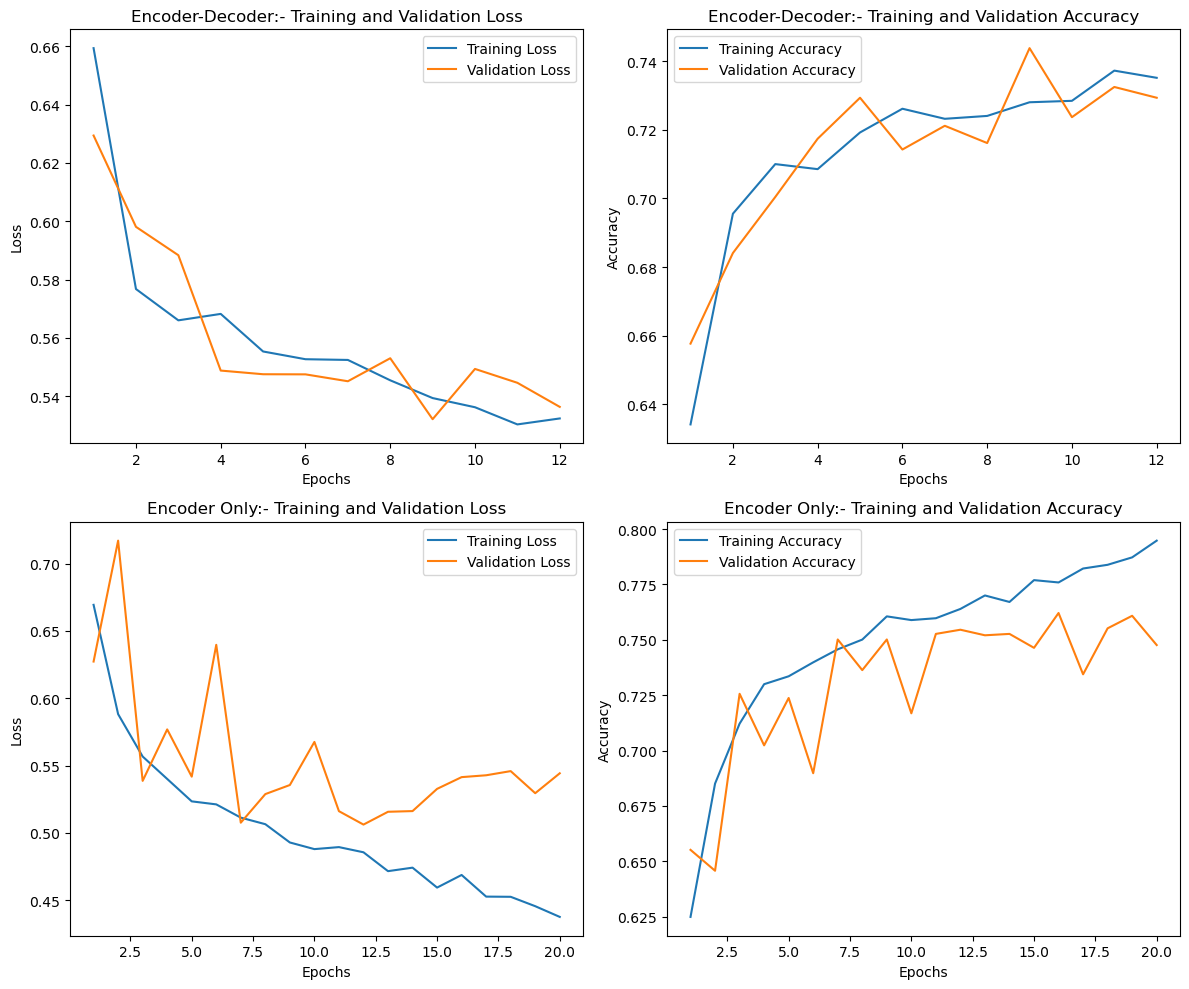

In [15]:
# Encoder - Decoder
ed_train_loss = ed_history.history['loss']
ed_val_loss = ed_history.history['val_loss']
ed_train_accuracy = ed_history.history['accuracy']  
ed_val_accuracy = ed_history.history['val_accuracy']
ed_epochs = range(1, len(ed_train_loss) + 1)  # Range of epochs (1 to number of epochs)

# Encoder only
e_train_loss = e_history.history['loss']
e_val_loss = e_history.history['val_loss']
e_train_accuracy = e_history.history['accuracy']  
e_val_accuracy = e_history.history['val_accuracy']
e_epochs = range(1, len(e_train_loss) + 1)  # Range of epochs (1 to number of epochs)

plt.figure(figsize=(12, 10))

# Subplot for the ED loss
plt.subplot(2, 2, 1)  
plt.plot(ed_epochs, ed_train_loss, label='Training Loss')
plt.plot(ed_epochs, ed_val_loss, label='Validation Loss')
plt.title('Encoder-Decoder:- Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot for the ED accuracy
plt.subplot(2, 2, 2)  
plt.plot(ed_epochs, ed_train_accuracy, label='Training Accuracy')
plt.plot(ed_epochs, ed_val_accuracy, label='Validation Accuracy')
plt.title('Encoder-Decoder:- Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for the E only loss
plt.subplot(2, 2, 3)  
plt.plot(e_epochs, e_train_loss, label='Training Loss')
plt.plot(e_epochs, e_val_loss, label='Validation Loss')
plt.title('Encoder Only:- Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot for the E only accuracy
plt.subplot(2, 2, 4) 
plt.plot(e_epochs, e_train_accuracy, label='Training Accuracy')
plt.plot(e_epochs, e_val_accuracy, label='Validation Accuracy')
plt.title('Encoder Only:- Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.tight_layout()  
plt.show()

In [16]:
# Make predictions on Encoder-Decoder
ed_test_predictions = transformer_model.predict(names_test)
ed_test_predicted_classes = np.argmax(ed_test_predictions, axis=1)

ed_pred_vs_actual = pd.concat([pd.Series(decoded_names_test),pd.Series(ed_test_predicted_classes).apply(label_map), pd.Series(labels_test).apply(label_map)],
                                     keys = ["name", "predicted", "actual"],axis=1)

print("#"*100)
print("Encoder-Decoder Pred vs Actual")
print(ed_pred_vs_actual)
print("#"*100)

50/50 [==============================] - 1s 7ms/step
####################################################################################################
Encoder-Decoder Pred vs Actual
            name predicted  actual
0        frannie    Female  Female
1     aleksandrs    Female    Male
2      nikoletta    Female  Female
3         gustaf      Male    Male
4          emlyn    Female  Female
...          ...       ...     ...
1584   annamaria    Female  Female
1585     stevena    Female  Female
1586    dionysus    Female    Male
1587       wally      Male  Female
1588       starr      Male  Female

[1589 rows x 3 columns]
####################################################################################################


In [17]:
# Make predictions on Encoder Only
e_test_predictions = encoder_only.predict(names_test)
e_test_predicted_classes = np.argmax(e_test_predictions, axis=1)

e_pred_vs_actual = pd.concat([pd.Series(decoded_names_test),pd.Series(e_test_predicted_classes).apply(label_map), pd.Series(labels_test).apply(label_map)],
                                     keys = ["name", "predicted", "actual"],axis=1)

print("#"*100)
print("Encoder Only Pred vs Actual")
print(e_pred_vs_actual)
print("#"*100)

50/50 [==============================] - 0s 4ms/step
####################################################################################################
Encoder Only Pred vs Actual
            name predicted  actual
0        frannie    Female  Female
1     aleksandrs      Male    Male
2      nikoletta      Male  Female
3         gustaf      Male    Male
4          emlyn    Female  Female
...          ...       ...     ...
1584   annamaria    Female  Female
1585     stevena    Female  Female
1586    dionysus      Male    Male
1587       wally      Male  Female
1588       starr    Female  Female

[1589 rows x 3 columns]
####################################################################################################


In [18]:
# Wrong Encode-Decoder predictions
print(ed_pred_vs_actual[ed_pred_vs_actual.predicted != ed_pred_vs_actual.actual])

            name predicted  actual
1     aleksandrs    Female    Male
5           vail    Female    Male
7           zary    Female    Male
13     zacharias    Female    Male
14      prentice    Female    Male
...          ...       ...     ...
1577      elmore    Female    Male
1579    hannibal    Female    Male
1586    dionysus    Female    Male
1587       wally      Male  Female
1588       starr      Male  Female

[412 rows x 3 columns]


In [19]:
# Wrong Encode Only predictions
print(e_pred_vs_actual[e_pred_vs_actual.predicted != e_pred_vs_actual.actual])

           name predicted  actual
2     nikoletta      Male  Female
5          vail    Female    Male
7          zary    Female    Male
14     prentice    Female    Male
17          sly    Female    Male
...         ...       ...     ...
1567       erek    Female    Male
1572     ingrid      Male  Female
1577     elmore    Female    Male
1579   hannibal    Female    Male
1587      wally      Male  Female

[379 rows x 3 columns]


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    return accuracy, precision, recall, f1

def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Use white text if squares are dark; otherwise black
    threshold = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [21]:
# Evaluate Encoder-Decoder Model
accuracy_ed, precision_ed, recall_ed, f1_ed = evaluate_model(transformer_model, names_test, labels_test)
print(f"Encoder-Decoder Model:-\nAccuracy: {accuracy_ed}\nPrecision: {precision_ed}\nRecall: {recall_ed}\nF1 Score: {f1_ed}")

50/50 [==============================] - 0s 7ms/step
Encoder-Decoder Model:-
Accuracy: 0.7407174323473883
Precision: 0.7481044650379107
Recall: 0.8871128871128872
F1 Score: 0.8117001828153566


In [22]:
# Evaluate Encoder only Model
accuracy_ed, precision_ed, recall_ed, f1_ed = evaluate_model(encoder_only, names_test, labels_test)
print(f"Encoder Only Model:-\nAccuracy: {accuracy_ed}\nPrecision: {precision_ed}\nRecall: {recall_ed}\nF1 Score: {f1_ed}")

50/50 [==============================] - 0s 4ms/step
Encoder Only Model:-
Accuracy: 0.7614852108244179
Precision: 0.768566493955095
Recall: 0.8891108891108891
F1 Score: 0.824455766558592


######################### Encoder-Decoder #########################


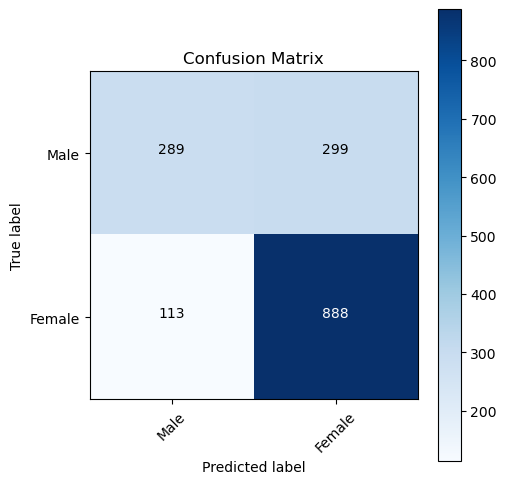

In [23]:
# Assuming test_predicted_classes and labels_test are already defined
print("#"*25, "Encoder-Decoder", "#"*25)
cm = confusion_matrix(labels_test, ed_test_predicted_classes)
plot_confusion_matrix(cm, ["Male", "Female"])

######################### Encoder Only #########################


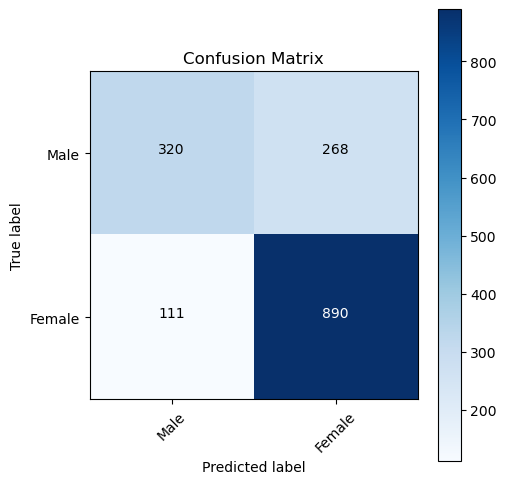

In [24]:
# Assuming test_predicted_classes and labels_test are already defined
print("#"*25, "Encoder Only", "#"*25)
cm = confusion_matrix(labels_test, e_test_predicted_classes)
plot_confusion_matrix(cm, ["Male", "Female"])